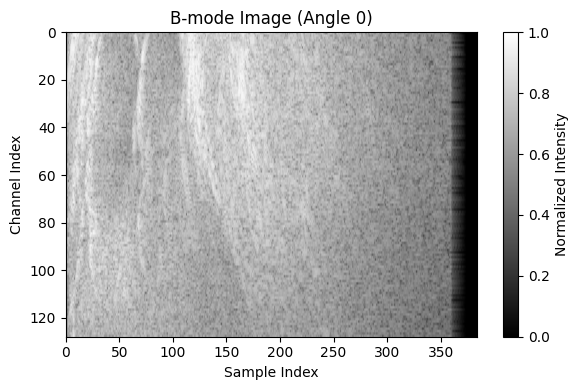

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

# Load HDF5 file
#file_path = "exp/datasets/PICMUS/carotid_cross_expe_dataset_iq.hdf5"
file_path = "exp/datasets/PICMUS/carotid_cross_expe_dataset_rf.hdf5"


with h5py.File(file_path, "r") as f:
    real = np.array(f["/US/US_DATASET0000/data/real"])  # shape: (75, 128, 384)
    imag = np.array(f["/US/US_DATASET0000/data/imag"])

# Combine real and imaginary parts
iq_data = real + 1j * imag  # Complex IQ data

# Select a frame (e.g., angle 0)
iq_frame = iq_data[1]  # shape: (128, 384)

# Compute envelope (magnitude)
envelope = np.abs(iq_frame)

# Log compression
log_env = 20 * np.log10(envelope + 1e-6)

# Normalize for display
bmode_image = (log_env - np.min(log_env)) / (np.max(log_env) - np.min(log_env))

# Plot B-mode image
plt.figure(figsize=(6, 4))
plt.imshow(bmode_image, cmap='gray', aspect='auto', extent=[0, 384, 128, 0])
plt.title("B-mode Image (Angle 0)")
plt.xlabel("Sample Index")
plt.ylabel("Channel Index")
plt.colorbar(label='Normalized Intensity')
plt.tight_layout()
plt.show()


In [4]:
# Crop the image to sample indices 0:300
iq_frame_cropped = iq_frame[:, :300]

# Envelope and log compression
envelope_cropped = np.abs(iq_frame_cropped)
log_env_cropped = 20 * np.log10(envelope_cropped + 1e-6)

# Normalize
#bmode_cropped = (log_env_cropped - np.min(log_env_cropped)) / (np.max(log_env_cropped) - np.min(log_env_cropped))

# Plot the cropped B-mode image
plt.figure(figsize=(6, 4))
plt.imshow(bmode_cropped, cmap='gray', aspect='auto', extent=[0, 300, 128, 0])
plt.title("B-mode Image (Angle 0, Sample 0–299)")
plt.xlabel("Sample Index")
plt.ylabel("Channel Index")
plt.colorbar(label='Normalized Intensity')
plt.tight_layout()
plt.show()


NameError: name 'bmode_cropped' is not defined

<Figure size 600x400 with 0 Axes>

In [10]:
# Save only the cropped complex IQ frame to a .mat file
mat_path_iq_only = "exp/datasets/PICMUS/iq_frame_cropped.mat"
sio.savemat(mat_path_iq_only, {"iq_frame_cropped": iq_frame_cropped})

### Experiment data

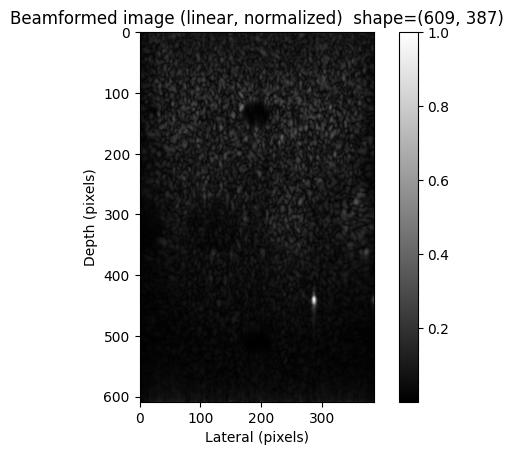

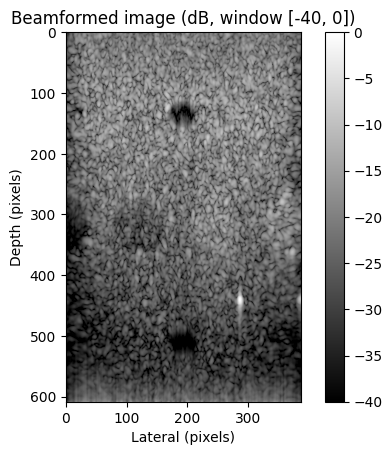

In [46]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

# Load the beamformed image
mat_path = "exp/datasets/PICMUS/Experimental_Data/exp_data2.mat"
mat = sio.loadmat(mat_path)
img = mat.get("data")
if img is None:
    raise ValueError("Could not find variable 'data' in exp_data.mat")

# Ensure float
img = np.asarray(img, dtype=np.float32)

# Linear magnitude view (normalized)
lin = np.abs(img)
lin_norm = lin / (lin.max() + 1e-12)

# dB view in [-40, 0] dB
db = 20.0 * np.log10(lin_norm + 1e-12)
vmin, vmax = -40.0, 0.0

# Show linear magnitude
plt.figure()
plt.imshow(lin_norm, cmap="gray", origin="upper", aspect="equal")
plt.colorbar()
plt.title(f"Beamformed image (linear, normalized)  shape={img.shape}")
plt.xlabel("Lateral (pixels)")
plt.ylabel("Depth (pixels)")
plt.show()

# Show dB compressed image
plt.figure()
plt.imshow(db, cmap="gray", origin="upper", aspect="equal", vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title("Beamformed image (dB, window [-40, 0])")
plt.xlabel("Lateral (pixels)")
plt.ylabel("Depth (pixels)")
plt.show()


In [47]:
import scipy.io
data = scipy.io.loadmat('exp/datasets/PICMUS/Experimental_Data/exp_data2.mat')
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'data'])


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
import scipy.io

# Load the data
data = scipy.io.loadmat('exp/datasets/PICMUS/Experimental_Data/exp_data2.mat')
rf = data['data'].astype(np.float64)
print('RF shape:', rf.shape)
print('RF range: min =', np.min(rf), ', max =', np.max(rf))

RF shape: (609, 387)
RF range: min = 0.003592966590076685 , max = 5.920960426330566


(512, 387)


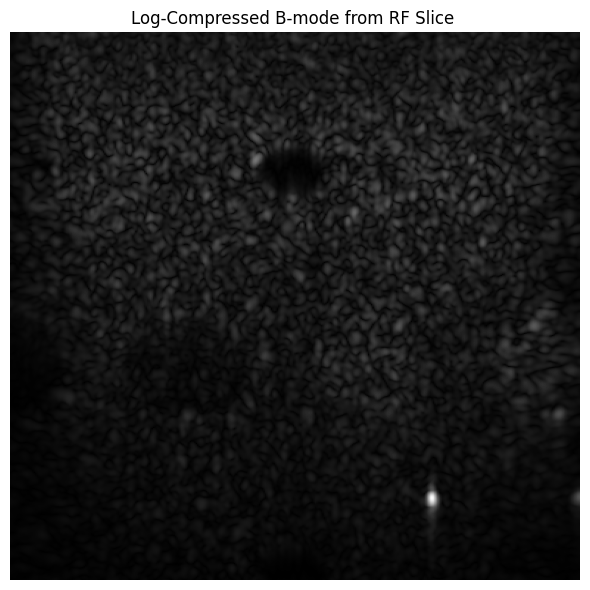

In [49]:
import numpy as np
import scipy.io
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# Load the .mat file
carotid_data = scipy.io.loadmat('exp/datasets/PICMUS/Experimental_Data/exp_data2.mat')
rf_data = carotid_data['data']

# Log compression baseline
LogB = 100

# Extract 512 rows starting from index 1000
rf_section = rf_data[5:5+512, :]

print(rf_section.shape)

# Apply Hilbert transform along depth axis
env = np.abs(rf_section)

# Log compression
log_env = np.log(env + LogB)

# Plot B-mode image
plt.figure(figsize=(6, 6))
plt.imshow(log_env, cmap='gray', aspect='auto')
plt.title('Log-Compressed B-mode from RF Slice ')
plt.axis('off')
plt.tight_layout()
plt.show()

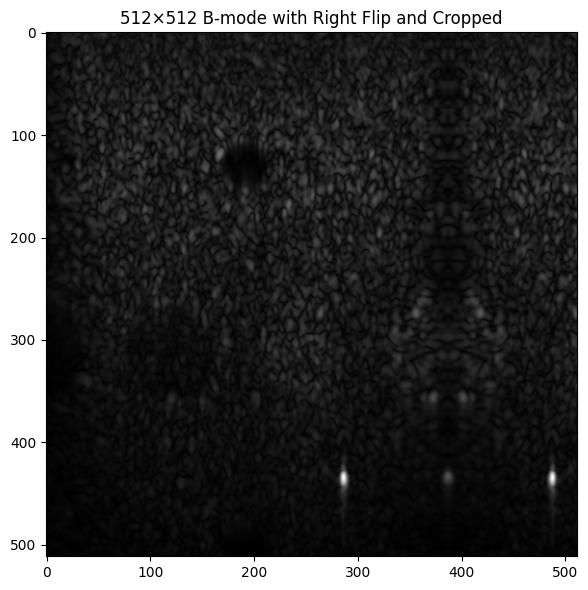

In [50]:
H, W = rf_section.shape

# Step 1: Copy original into new 512×512 matrix
rf_filled = np.zeros((512, 512), dtype=rf_section.dtype)
rf_filled[:, :W] = rf_section

# Step 2: Fill remaining with flipped rightmost part
fill_width = 512 - W
rf_filled[:, W:] = np.fliplr(rf_section[:, -fill_width:])

# Step 3: Hilbert transform + log compression
LogB = 500
env = np.abs((rf_filled))
log_env = np.log(env + LogB)

# Plot the final 512×512 result
plt.figure(figsize=(6, 6))
plt.imshow(log_env, cmap='gray', aspect='auto')
plt.title('512×512 B-mode with Right Flip and Cropped')
plt.axis('on')
plt.tight_layout()
plt.show()

In [51]:
rf_filled.shape

(512, 512)

In [52]:
print('RF range: min =', np.min(rf_filled), ', max =', np.max(rf_filled))

RF range: min = 0.0035929666 , max = 5.9209604


In [53]:
rfn = rf_filled / np.max(np.abs(rf_filled))
print('RF range: min =', np.min(rfn), ', max =', np.max(rfn))

RF range: min = 0.00060682156 , max = 1.0


In [54]:
import scipy.io

# Save only the 512×512 RF matrix
scipy.io.savemat('exp/datasets/PICMUS/Experimental_Data/rf2_ddrm.mat', {'data': rf_filled})
scipy.io.savemat('exp/datasets/PICMUS/Experimental_Data/rfn2_ddrm.mat', {'data': rfn})

In [15]:
# Load the estimated PSF from the uploaded psf.mat file
psf_mat_path = 'exp/datasets/PICMUS/Experimental_Data/exp_data1_psf.mat'
psf_data = scipy.io.loadmat(psf_mat_path)

# List keys to identify the PSF variable
psf_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'cropped_psf'])

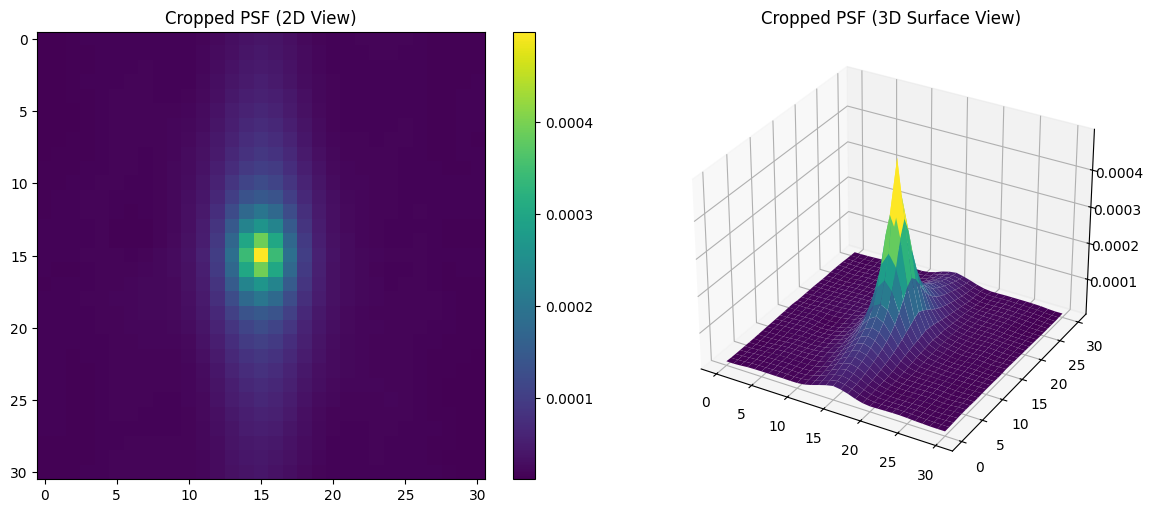

In [2]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the cropped PSF from the uploaded .mat file
mat = scipy.io.loadmat('exp/datasets/PICMUS/Experimental_Data/exp_data1_psf.mat')
cropped_psf = mat['cropped_psf']

# Plot the 2D image
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(cropped_psf, cmap='viridis')
plt.title('Cropped PSF (2D View)')
plt.axis('image')
plt.colorbar()

# Plot the 3D surface
ax = plt.subplot(1, 2, 2, projection='3d')
x = np.arange(cropped_psf.shape[1])
y = np.arange(cropped_psf.shape[0])
x, y = np.meshgrid(x, y)
ax.plot_surface(x, y, cropped_psf, cmap='viridis', edgecolor='none')
ax.set_title('Cropped PSF (3D Surface View)')

plt.tight_layout()
plt.show()


## Tikhonov Deconvolution

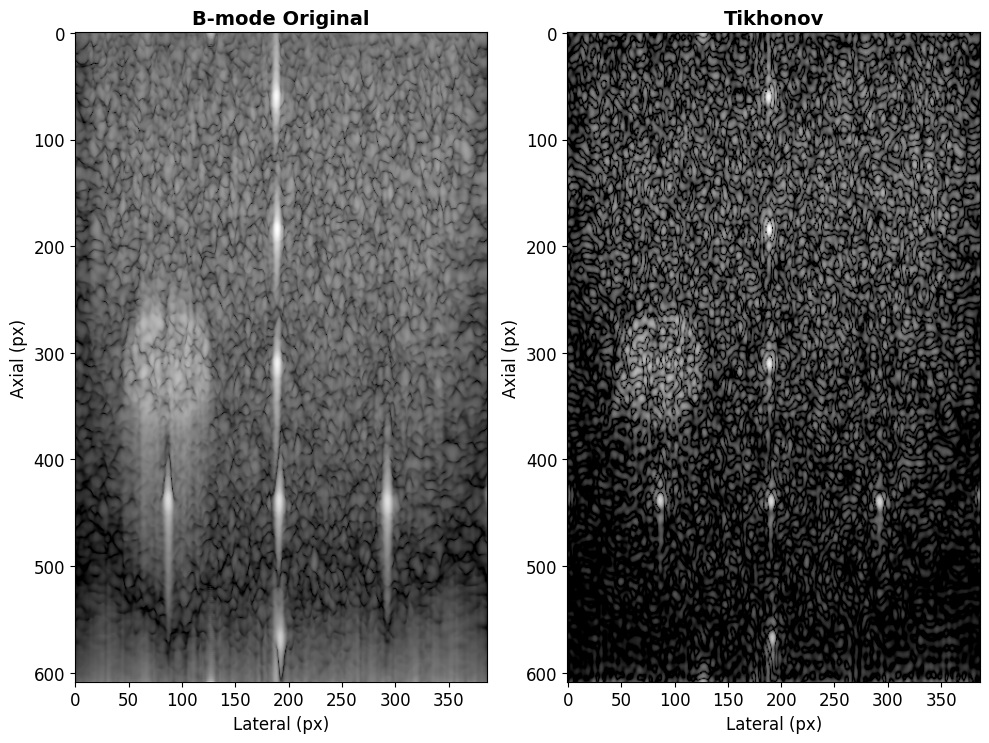

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert, correlate
import warnings
warnings.filterwarnings('ignore')

# 1. Load raw RF data
data = loadmat('exp/datasets/PICMUS/Experimental_Data/exp_data1.mat')
rf = data['data']
rfn = rf / np.max(np.abs(rf))  # normalized RF

# 2. Tikhonov restoration (Wiener filter)
psf_data = loadmat('exp/datasets/PICMUS/Experimental_Data/new_psf.mat')
H = psf_data['cropped_psf']
h = H / np.sum(np.abs(H))
Mh, Nh = H.shape
center = np.round(np.array([Mh, Nh])/2).astype(int)

pad_h = np.pad(h, ((0, rf.shape[0]-Mh), (0, rf.shape[1]-Nh)), mode='constant')
pad_h = np.roll(pad_h, 1-center[0], axis=0)
pad_h = np.roll(pad_h, 1-center[1], axis=1)

D = np.fft.fft2(pad_h)
SNR_val = 500  # ~60 dB
VivoTK = np.fft.ifft2(np.fft.fft2(rfn) * np.conj(D) / (SNR_val**(-1) + np.conj(D)*D)).real

# 3. Envelope detection and log compression
M, N = rf.shape
rf = rf[:M, :N]
VivoTK = VivoTK[:M, :N]

# Raw data processing
env_raw = np.abs(hilbert(rf, axis=0))
env_raw = env_raw / np.max(env_raw)
bmode_raw = 20 * np.log10(env_raw + np.finfo(float).eps)
#bmode_raw = np.maximum(bmode_raw, -50)

# Tikhonov processing
env_tikh = np.abs(VivoTK)
env_tikh = env_tikh / np.max(env_tikh)
bmode_tikh = 20 * np.log10(env_tikh + np.finfo(float).eps)
#bmode_tikh = np.maximum(bmode_tikh, -50)



# 5. Visualization
fig = plt.figure(figsize=(10, 8))
fig.canvas.manager.set_window_title('B-mode Comparison')

titles = ['B-mode Original', 'Tikhonov']
images = [bmode_raw, bmode_tikh]

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    im = ax.imshow(images[i], cmap='gray', vmin=-50, vmax=0, aspect='equal')
    ax.set_title(titles[i], fontsize=14, fontweight='bold')
    ax.set_xlabel('Lateral (px)', fontsize=12)
    ax.set_ylabel('Axial (px)', fontsize=12)
    ax.tick_params(labelsize=12)

#plt.subplots_adjust(right=0.9)
#cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
#cbar = fig.colorbar(im, cax=cbar_ax)
#cbar.set_label('Amplitude (dB)', fontsize=12)
#cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()


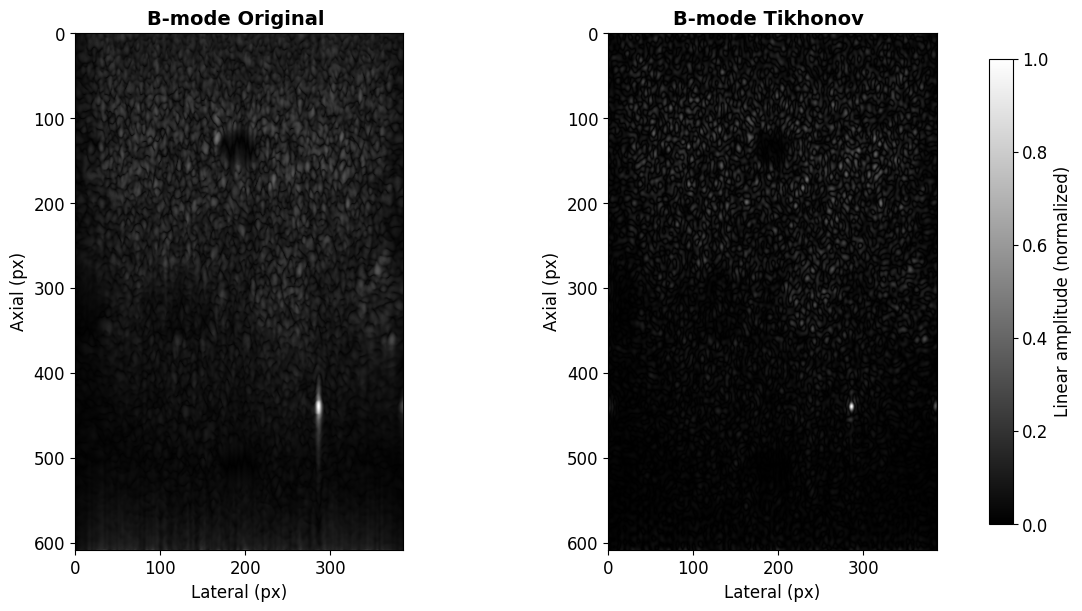

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert
import warnings
warnings.filterwarnings('ignore')

# ------------------------------
# 1. Load raw RF data
# ------------------------------
data = loadmat('exp/datasets/PICMUS/Experimental_Data/exp_data2.mat')
rf = data['data'].astype(float)
rfn = rf / np.max(np.abs(rf))  # normalized RF

# ------------------------------
# 2. Tikhonov restoration (Wiener filter) with your new PSF
# ------------------------------
psf_data = loadmat('exp/datasets/PICMUS/Experimental_Data/new_psf_exp2.mat')
H = psf_data['cropped_psf'].astype(float)
h = H / np.sum(np.abs(H))
Mh, Nh = H.shape
center = np.round(np.array([Mh, Nh]) / 2).astype(int)

pad_h = np.pad(h, ((0, rf.shape[0]-Mh), (0, rf.shape[1]-Nh)), mode='constant')
pad_h = np.roll(pad_h, 1-center[0], axis=0)
pad_h = np.roll(pad_h, 1-center[1], axis=1)

D = np.fft.fft2(pad_h)
SNR_val = 500 # ~54 dB
VivoTK = np.fft.ifft2(np.fft.fft2(rfn) * np.conj(D) / (SNR_val**(-1) + np.conj(D)*D)).real

# Trim (already same size)
M, N = rf.shape
rf = rf[:M, :N]
VivoTK = VivoTK[:M, :N]

# ------------------------------
# 3. Visualization WITHOUT log
# ------------------------------
# Envelope (linear) and normalize 0..1
env_raw = np.abs(hilbert(rf, axis=0))
env_raw /= (env_raw.max() + 1e-12)

env_tikh = np.abs(VivoTK)
env_tikh /= (env_tikh.max() + 1e-12)

# Side-by-side with shared colorbar
fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
titles = ['B-mode Original ', 'B-mode Tikhonov ']
images = [env_raw, env_tikh]

for ax, im, title in zip(axes, images, titles):
    imh = ax.imshow(im, cmap='gray', vmin=0, vmax=1, aspect='equal', origin='upper')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Lateral (px)', fontsize=12)
    ax.set_ylabel('Axial (px)', fontsize=12)
    ax.tick_params(labelsize=12)

cbar = fig.colorbar(imh, ax=axes.ravel().tolist(), shrink=0.9)
cbar.set_label('Linear amplitude (normalized)', fontsize=12)
cbar.ax.tick_params(labelsize=12)

plt.show()


In [27]:
import numpy as np
from scipy.io import loadmat
from scipy.signal import hilbert
from skimage.metrics import structural_similarity as ssim

# -------------------------
# Simple metrics: Resolution (FWHM), PSNR, SSIM
# -------------------------

# 1) Load inputs
rf   = loadmat('exp/datasets/PICMUS/Experimental_Data/exp_data1.mat')["data"].astype(float)            # beamformed image
psf  = loadmat('exp/datasets/PICMUS/Experimental_Data/new_psf.mat')["cropped_psf"].astype(float)       # PSF for Tikhonov
#psf  = loadmat('exp/datasets/PICMUS/Experimental_Data/exp_data1_psf.mat')["cropped_psf"].astype(float) 
# 2) Envelopes
env_raw = np.abs(hilbert(rf, axis=0))
env_raw /= env_raw.max() + 1e-12

# Tikhonov (Wiener-like) deconvolution
rfn = rf / (np.max(np.abs(rf)) + 1e-12)
mh, nh = psf.shape
M, N = rfn.shape
pad_h = np.zeros_like(rfn)
pad_h[:mh, :nh] = psf
pad_h = np.roll(pad_h, -mh//2, axis=0)
pad_h = np.roll(pad_h, -nh//2, axis=1)
H = np.fft.fft2(pad_h)
Y = np.fft.fft2(rfn)
SNR_val = 1000.0                    # adjust as desired
Xhat = (np.conj(H) * Y) / ((np.conj(H)*H) + (1.0 / SNR_val))
tikh = np.fft.ifft2(Xhat).real

env_tikh = np.abs(tikh)
env_tikh /= env_tikh.max() + 1e-12

# 3) Resolution (FWHM) for each image at a bright target near mid-depth
def fwhm_1d(y):
    y = y / (y.max() + 1e-12)
    idx = np.where(y >= 0.5)[0]
    return (idx[-1] - idx[0] + 1) if len(idx) >= 2 else np.nan

def psf_patch(img, half=15):
    Nz, Nx = img.shape
    col = Nx // 2
    row = 150 + np.argmax(img[150:500, col])  # pick a bright point in mid-depth
    r0, r1 = max(0, row-half), min(Nz, row+half+1)
    c0, c1 = max(0, col-half), min(Nx, col+half+1)
    patch = img[r0:r1, c0:c1]
    # pad to fixed size if near borders
    pad_r0 = half - (row - r0); pad_r1 = half - (r1 - row - 1)
    pad_c0 = half - (col - c0); pad_c1 = half - (c1 - col - 1)
    return np.pad(patch, ((pad_r0, pad_r1), (pad_c0, pad_c1)), mode='edge')

half = 15
p_raw  = psf_patch(env_raw, half)
p_tikh = psf_patch(env_tikh, half)

lat_raw = fwhm_1d(p_raw[half, :]);   ax_raw = fwhm_1d(p_raw[:, half])
lat_tik = fwhm_1d(p_tikh[half, :]);  ax_tik = fwhm_1d(p_tikh[:, half])

# 4) PSNR & SSIM between images (using original envelope as reference)
mse = np.mean((env_tikh - env_raw) ** 2)
psnr_val = 20 * np.log10(1.0 / np.sqrt(mse + 1e-12))  # max signal = 1
ssim_val = ssim(env_raw, env_tikh, data_range=1.0)

# 5) Print concise results
print("Resolution (FWHM in pixels):")
print(f"  Original  - Axial: {ax_raw:.1f}  |  Lateral: {lat_raw:.1f}")
print(f"  Tikhonov  - Axial: {ax_tik:.1f}  |  Lateral: {lat_tik:.1f}\n")
print(f"PSNR (Tikhonov vs Original): {psnr_val:.2f} dB")
print(f"SSIM (Tikhonov vs Original): {ssim_val:.4f}")


Resolution (FWHM in pixels):
  Original  - Axial: 22.0  |  Lateral: 6.0
  Tikhonov  - Axial: 7.0  |  Lateral: 4.0

PSNR (Tikhonov vs Original): 29.28 dB
SSIM (Tikhonov vs Original): 0.6368


In [28]:

# ---------- Resolution (FWHM) ----------
def fwhm_1d(y):
    y = y / (y.max() + 1e-12)
    idx = np.where(y >= 0.5)[0]
    return (idx[-1] - idx[0] + 1) if len(idx) >= 2 else np.nan

def psf_patch(img, half=15):
    Nz, Nx = img.shape
    col = Nx // 2
    row = 150 + np.argmax(img[150:500, col])
    r0, r1 = row-half, row+half+1
    c0, c1 = col-half, col+half+1
    patch = img[max(0,r0):min(Nz,r1), max(0,c0):min(Nx,c1)]
    return np.pad(patch, ((max(0,-r0), max(0,r1-Nz)), (max(0,-c0), max(0,c1-Nx))), mode='edge')

half = 15
p_raw  = psf_patch(env_raw, half)
p_tikh = psf_patch(env_tikh, half)

lat_raw = fwhm_1d(p_raw[half,:]); ax_raw = fwhm_1d(p_raw[:,half])
lat_tik = fwhm_1d(p_tikh[half,:]); ax_tik = fwhm_1d(p_tikh[:,half])

# Gains
gain_ax  = ax_raw / ax_tik if ax_tik>0 else np.nan
gain_lat = lat_raw / lat_tik if lat_tik>0 else np.nan

# ---------- PSNR & SSIM ----------
mse = np.mean((env_tikh - env_raw) ** 2)
psnr_val = 20*np.log10(1.0 / np.sqrt(mse + 1e-12))
ssim_val = ssim(env_raw, env_tikh, data_range=1.0)

# ---------- Print results ----------
print("Resolution (FWHM in pixels):")
print(f"  Original  - Axial: {ax_raw:.1f}  |  Lateral: {lat_raw:.1f}")
print(f"  Tikhonov  - Axial: {ax_tik:.1f}  |  Lateral: {lat_tik:.1f}")
print(f"  Gain      - Axial: {gain_ax:.2f}x |  Lateral: {gain_lat:.2f}x\n")


Resolution (FWHM in pixels):
  Original  - Axial: 22.0  |  Lateral: 6.0
  Tikhonov  - Axial: 7.0  |  Lateral: 4.0
  Gain      - Axial: 3.14x |  Lateral: 1.50x



## Making new psf by cropping one point in data

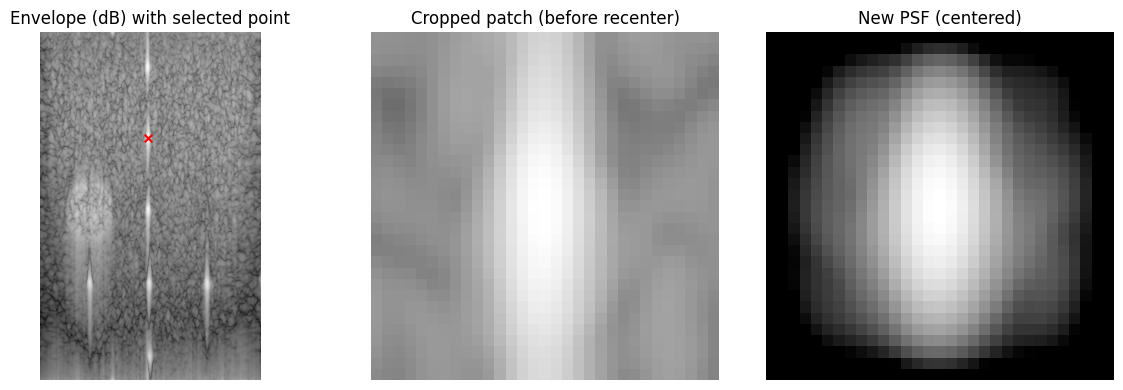

'exp/datasets/PICMUS/Experimental_Data/new_psf.mat'

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter

# --- Load beamformed image (RF-like) ---
img = loadmat("exp/datasets/PICMUS/Experimental_Data/exp_data1.mat")["data"].astype(np.float64)  # [Nz x Nx]

# --- Build envelope to detect bright point targets ---
env = np.abs(hilbert(img, axis=0))        # analytic along depth
env = env / (env.max() + 1e-12)
env_s = gaussian_filter(env, sigma=1.0)   # light smoothing for robust peak pick

# --- Choose a target peak ---
# If you want a specific point, set a seed (z0, x0) in pixels; else use global max
z0, x0 = np.unravel_index(np.argmax(env_s), env_s.shape)

# --- Crop a square PSF patch around the chosen peak ---
patch_size = 31  # odd size so there's a clear center
half = patch_size // 2

# Pad image to handle edges safely
pad_z, pad_x = (half+2, half+2)
env_pad = np.pad(env_s, ((pad_z, pad_z), (pad_x, pad_x)), mode='reflect')

# Shift indices because of padding
z0p, x0p = z0 + pad_z, x0 + pad_x

# Extract patch
patch = env_pad[z0p-half:z0p+half+1, x0p-half:x0p+half+1]

# --- Recentre: circularly shift so the brightest pixel is at the center ---
zi, xi = np.unravel_index(np.argmax(patch), patch.shape)
cz, cx = half, half
shift_z = cz - zi
shift_x = cx - xi
psf_centered = np.roll(np.roll(patch, shift_z, axis=0), shift_x, axis=1)

# Optional: window to reduce boundary effects (Hann 2D)
win1 = np.hanning(patch_size)
win2d = np.outer(win1, win1)
psf_centered = psf_centered * win2d

# Normalize PSF energy
psf_centered /= (psf_centered.sum() + 1e-12)

# Save to MAT for your pipeline
out_path = "exp/datasets/PICMUS/Experimental_Data/new_psf.mat"
savemat(out_path, {"cropped_psf": psf_centered, "center_idx": np.array([[cz, cx]]), "patch_size": patch_size})

# --- Visualize ---
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(20*np.log10(env + 1e-12), cmap="gray", vmin=-60, vmax=0, origin="upper", aspect="equal")
axs[0].scatter([x0], [z0], s=30, c="r", marker="x")
axs[0].set_title("Envelope (dB) with selected point")
axs[0].set_axis_off()

axs[1].imshow(20*np.log10(patch/patch.max() + 1e-12), cmap="gray", vmin=-60, vmax=0, origin="upper", aspect="equal")
axs[1].set_title("Cropped patch (before recenter)")
axs[1].set_axis_off()

axs[2].imshow(20*np.log10(psf_centered/psf_centered.max() + 1e-12), cmap="gray", vmin=-60, vmax=0, origin="upper", aspect="equal")
axs[2].set_title("New PSF (centered)")
axs[2].set_axis_off()

plt.tight_layout()
plt.show()

out_path


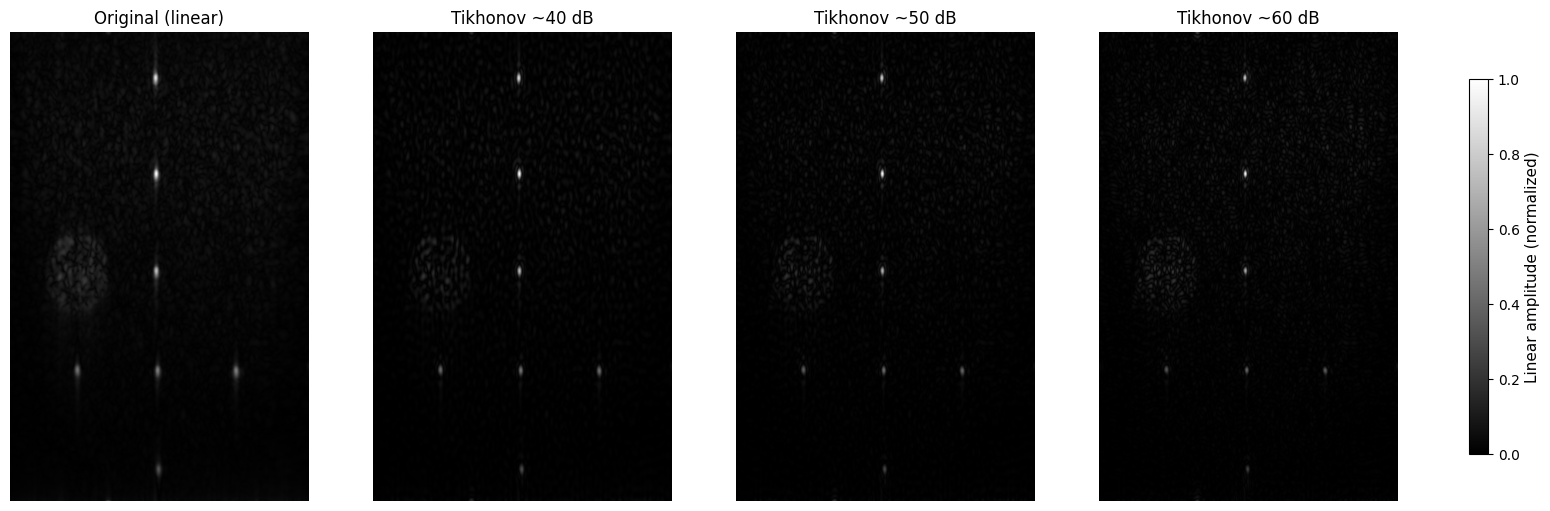

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Load inputs (same files as before)
img = loadmat("exp/datasets/PICMUS/Experimental_Data/exp_data1.mat")["data"].astype(np.float64)
psf = loadmat("exp/datasets/PICMUS/Experimental_Data/new_psf.mat")["cropped_psf"].astype(np.float64)

# Normalize image
img_n = img / (np.max(np.abs(img)) + 1e-12)

# Build centered, zero-padded PSF
M, N = img_n.shape
Mh, Nh = psf.shape
pad_h = np.zeros_like(img_n)
pad_h[:Mh, :Nh] = psf
cz, cx = Mh//2, Nh//2
pad_h = np.roll(pad_h, -cz, axis=0)
pad_h = np.roll(pad_h, -cx, axis=1)

# FFTs
H = np.fft.fft2(pad_h)
Y = np.fft.fft2(img_n)

def tikhonov_deconv(Y, H, snr):
    denom = (np.conj(H) * H) + (1.0 / snr)
    Xhat = (np.conj(H) * Y) / denom
    return np.fft.ifft2(Xhat).real

snrs = [100.0, 316.0, 1000.0]  # ~40, ~50, ~60 dB
restored = [tikhonov_deconv(Y, H, s) for s in snrs]

# Linear magnitude (NO LOG), normalized 0..1 for display
def lin_mag(im):
    im = np.abs(im)
    return im / (im.max() + 1e-12)

to_show = [lin_mag(img_n)] + [lin_mag(r) for r in restored]
titles = ["Original (linear)", "Tikhonov ~40 dB", "Tikhonov ~50 dB", "Tikhonov ~60 dB"]

# Plot with shared colorbar [0,1]
fig, axs = plt.subplots(1, 4, figsize=(16, 5), constrained_layout=True)
for ax, im, t in zip(axs, to_show, titles):
    imh = ax.imshow(im, cmap="gray", vmin=0, vmax=1, aspect="equal", origin="upper")
    ax.set_title(t, fontsize=12)
    ax.axis("off")

cbar = fig.colorbar(imh, ax=axs.ravel().tolist(), shrink=0.8)
cbar.set_label("Linear amplitude (normalized)", fontsize=11)
cbar.ax.tick_params(labelsize=10)

plt.show()


### Experimental data 2

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter
from skimage.metrics import structural_similarity as ssim

# ---------- Load exp_data2 ----------
img2 = loadmat("exp/datasets/PICMUS/Experimental_Data/exp_data2.mat")
rf2 = img2.get("data")
if rf2 is None:
    # fallback: first non-internal
    k = [k for k in img2.keys() if not k.startswith("__")][0]
    rf2 = img2[k]
rf2 = rf2.astype(float)

# ---------- Build envelope for PSF detection ----------
env2 = np.abs(hilbert(rf2, axis=0))
env2 /= env2.max() + 1e-12
env2_s = gaussian_filter(env2, sigma=1.0)

# ---------- Crop a centered PSF patch around a bright mid-depth point ----------
Nz, Nx = env2.shape
# choose a row in mid-depth band to avoid shallow artifacts
mid_band = env2_s[120:min(500, Nz), :]
zi_off, xi = np.unravel_index(np.argmax(mid_band), mid_band.shape)
zi = 120 + zi_off

patch_size = 31
half = patch_size // 2

# pad-reflect to handle edges
pad = ((half+2, half+2), (half+2, half+2))
env_pad = np.pad(env2_s, pad, mode="reflect")
zi_p, xi_p = zi + pad[0][0], xi + pad[1][0]
patch = env_pad[zi_p-half:zi_p+half+1, xi_p-half:xi_p+half+1]

# recenter brightest pixel to center
zi0, xi0 = np.unravel_index(np.argmax(patch), patch.shape)
cz, cx = half, half
psf = np.roll(np.roll(patch, cz - zi0, axis=0), cx - xi0, axis=1)

# optional Hann window to reduce edge effects; normalize energy
win = np.hanning(patch_size)
win2d = np.outer(win, win)
psf *= win2d
psf /= psf.sum() + 1e-12

# Save PSF for this dataset
savemat("exp/datasets/PICMUS/Experimental_Data/new_psf_exp2.mat", {"cropped_psf": psf})

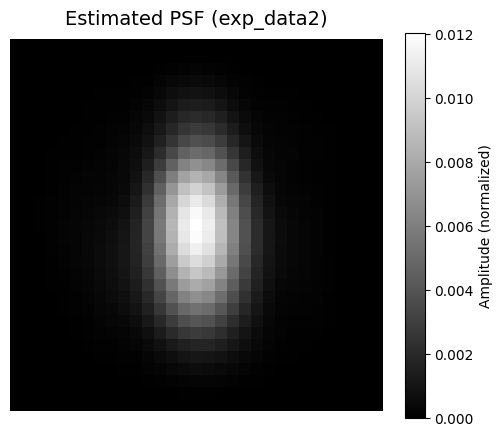

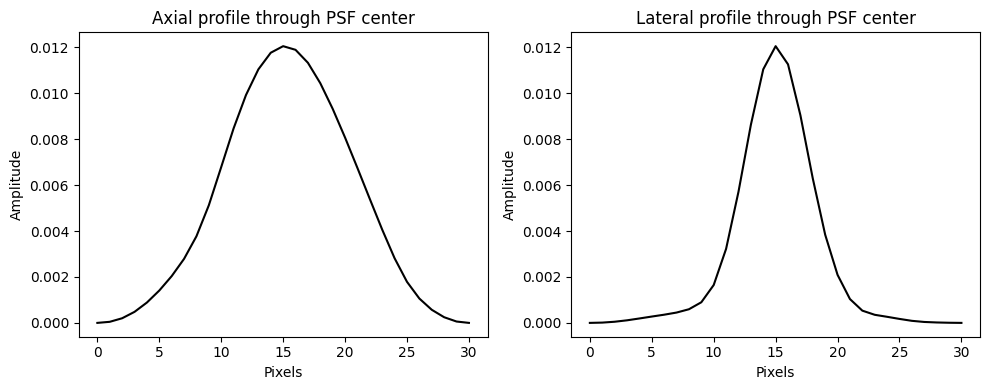

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

# Load the PSF saved earlier for exp_data2
psf2 = loadmat("exp/datasets/PICMUS/Experimental_Data/new_psf_exp2.mat")["cropped_psf"].astype(float)

plt.figure(figsize=(6,5))
plt.imshow(psf2, cmap="gray", origin="upper")
plt.title("Estimated PSF (exp_data2)", fontsize=14)
plt.colorbar(label="Amplitude (normalized)")
plt.axis("equal"); plt.axis("off")
plt.show()

# Also show central line profiles (axial vs lateral)
cz, cx = psf2.shape[0]//2, psf2.shape[1]//2
axial_prof = psf2[:, cx]
lateral_prof = psf2[cz, :]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(axial_prof, 'k-')
plt.title("Axial profile through PSF center")
plt.xlabel("Pixels"); plt.ylabel("Amplitude")

plt.subplot(1,2,2)
plt.plot(lateral_prof, 'k-')
plt.title("Lateral profile through PSF center")
plt.xlabel("Pixels"); plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


In [73]:
# Load the estimated PSF from the uploaded psf.mat file
psf_mat_path = 'exp/datasets/PICMUS/Experimental_Data/rf2_ddrm.mat'
psf_data = scipy.io.loadmat(psf_mat_path)

# List keys to identify the PSF variable
psf_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data'])

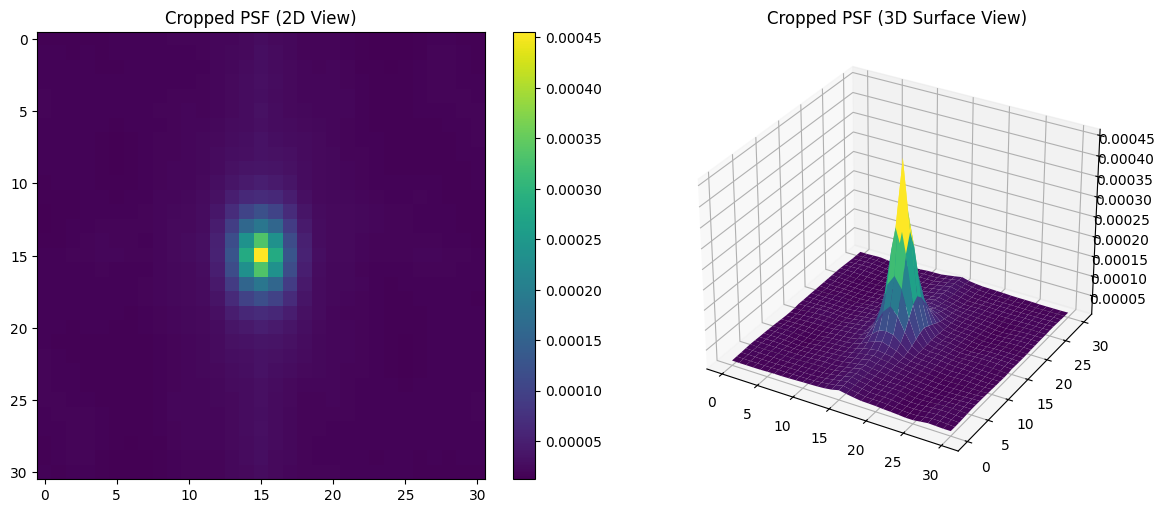

In [66]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the cropped PSF from the uploaded .mat file
mat = scipy.io.loadmat('exp/datasets/PICMUS/Experimental_Data/psf_exp2.mat')
cropped_psf = mat['cropped_psf']

# Plot the 2D image
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(cropped_psf, cmap='viridis')
plt.title('Cropped PSF (2D View)')
plt.axis('image')
plt.colorbar()

# Plot the 3D surface
ax = plt.subplot(1, 2, 2, projection='3d')
x = np.arange(cropped_psf.shape[1])
y = np.arange(cropped_psf.shape[0])
x, y = np.meshgrid(x, y)
ax.plot_surface(x, y, cropped_psf, cmap='viridis', edgecolor='none')
ax.set_title('Cropped PSF (3D Surface View)')

plt.tight_layout()
plt.show()

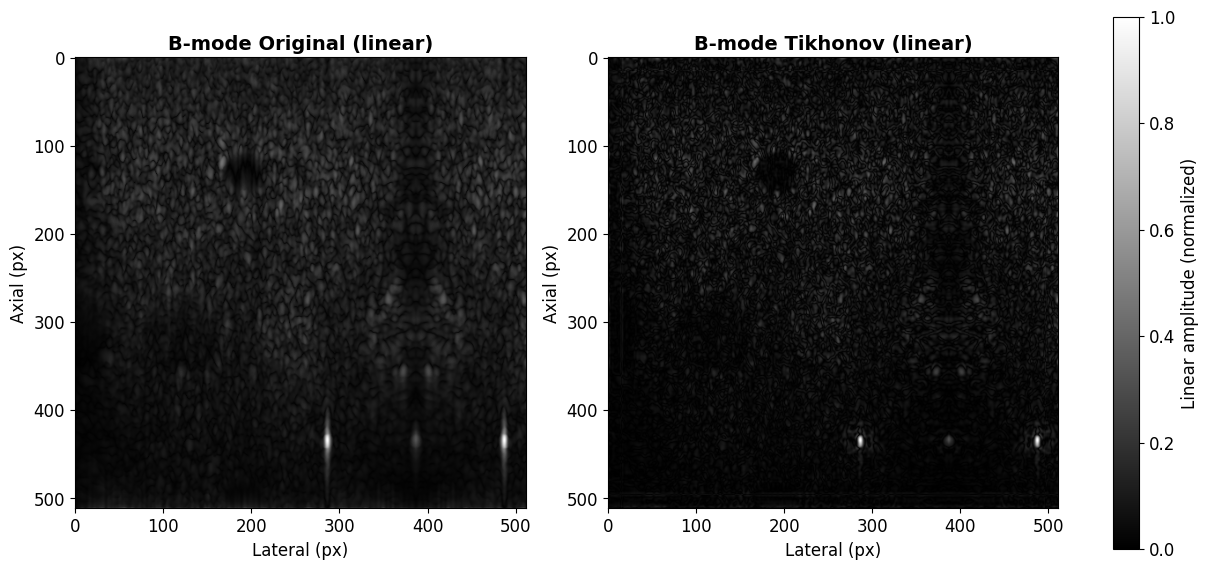

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert
import warnings
warnings.filterwarnings('ignore')

# ------------------------------
# 1. Load raw RF data (local paths)
# ------------------------------
data = loadmat('exp/datasets/PICMUS/Experimental_Data/rf2_ddrm.mat')
rf = data['data'].astype(float)
rfn = rf / np.max(np.abs(rf))  # normalized RF

# ------------------------------
# 2. Tikhonov restoration (Wiener filter) with your new PSF
# ------------------------------
psf_data = loadmat('exp/datasets/PICMUS/Experimental_Data/psf_exp2_oleg.mat')
H = psf_data['cropped_psf'].astype(float)
h = H / np.sum(np.abs(H))
Mh, Nh = H.shape
center = np.round(np.array([Mh, Nh]) / 2).astype(int)

pad_h = np.pad(h, ((0, rf.shape[0]-Mh), (0, rf.shape[1]-Nh)), mode='constant')
pad_h = np.roll(pad_h, 1-center[0], axis=0)
pad_h = np.roll(pad_h, 1-center[1], axis=1)

D = np.fft.fft2(pad_h)
SNR_val = 1000.0  # ~54 dB
VivoTK = np.fft.ifft2(np.fft.fft2(rfn) * np.conj(D) / (SNR_val**(-1) + np.conj(D)*D)).real

# Trim (already same size)
M, N = rf.shape
rf = rf[:M, :N]
VivoTK = VivoTK[:M, :N]

# ------------------------------
# 3. Visualization WITHOUT log
# ------------------------------
# Envelope (linear) and normalize 0..1
env_raw = np.abs(hilbert(rf, axis=0))
env_raw /= (env_raw.max() + 1e-12)

env_tikh = np.abs(VivoTK)
env_tikh /= (env_tikh.max() + 1e-12)

# Side-by-side with shared colorbar
fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
titles = ['B-mode Original (linear)', 'B-mode Tikhonov (linear)']
images = [env_raw, env_tikh]

for ax, im, title in zip(axes, images, titles):
    imh = ax.imshow(im, cmap='gray', vmin=0, vmax=1, aspect='equal', origin='upper')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Lateral (px)', fontsize=12)
    ax.set_ylabel('Axial (px)', fontsize=12)
    ax.tick_params(labelsize=12)

cbar = fig.colorbar(imh, ax=axes.ravel().tolist(), shrink=0.9)
cbar.set_label('Linear amplitude (normalized)', fontsize=12)
cbar.ax.tick_params(labelsize=12)

plt.show()


### DDRM

In [77]:
folder_name = "Picmus_Exp"

In [87]:
!python main.py --ni --config Deconv_picmus1.yml --doc imagenet_ood --timesteps 20 --eta 0.85 --etaB 1 --deg deblur_bccb --sigma_0 20 -i {folder_name}

Module path: /projects/minds/PDAS-M2-2025/DDPM
Current sys.path: ['/projects/minds/PDAS-M2-2025/Stable_DDRM', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '/home/pdas/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/local/lib/python3.10/dist-packages/nvfuser-0.1.4a0+d0bb811-py3.10-linux-x86_64.egg', '/usr/lib/python3/dist-packages', '/projects/minds/PDAS-M2-2025/DDPM']
File not found: /projects/minds/PDAS-M2-2025/DDPM/denoising_diffusion_pytorch.py
Import failed: No module named 'denoising_diffusion_pytorch'
INFO - main.py - 2025-08-27 16:11:13,944 - Using device: cuda
INFO - main.py - 2025-08-27 16:11:13,945 - Writing log file to exp/logs/imagenet_ood
INFO - main.py - 2025-08-27 16:11:13,945 - Exp instance id = 3832978
INFO - main.py - 2025-08-27 16:11:13,945 - Exp comment = 
building dataset from exp/picmus.txt
read meta done
Start from 0
  0%|                                                     | 0/1 [00:00

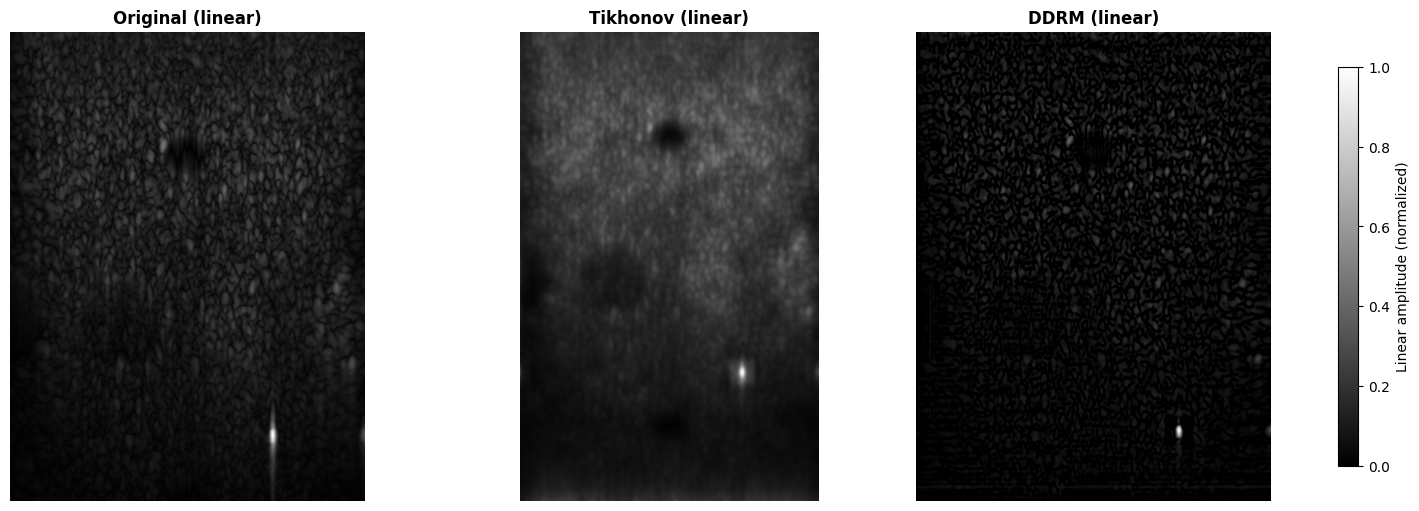

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert

# ---------- Load original RF image ----------
rf = loadmat('exp/datasets/PICMUS/Experimental_Data/exp_data2.mat')["data"].astype(float)

# ---------- Tikhonov with previously built PSF ----------
psf = loadmat('exp/datasets/PICMUS/Experimental_Data/psf_exp2_oleg.mat')["cropped_psf"].astype(float)
rfn = rf / (np.max(np.abs(rf)) + 1e-12)

# Centered, zero-padded PSF
mh, nh = psf.shape
M, N = rfn.shape
pad_h = np.zeros_like(rfn)
pad_h[:mh, :nh] = psf
pad_h = np.roll(pad_h, -mh//2, axis=0)
pad_h = np.roll(pad_h, -nh//2, axis=1)

H = np.fft.fft2(pad_h)
Y = np.fft.fft2(rfn)
SNR_val = 1000.0
VivoTK = np.fft.ifft2((np.conj(H) * Y) / ((np.conj(H)*H) + (1.0/SNR_val))).real

# Envelopes (linear, normalized) for fair visual
env_raw = np.abs(hilbert(rf, axis=0)); env_raw /= (env_raw.max() + 1e-12)
env_tikh = np.abs(VivoTK);            env_tikh /= (env_tikh.max() + 1e-12)

# ---------- Load DDRM output ----------
ddrm_mat = loadmat('exp/image_samples/Picmus_Exp/0_-1.mat')
# get variable named 'image' if exists; else pick first non-internal
if 'image' in ddrm_mat:
    im = ddrm_mat['image']
else:
    keys = [k for k in ddrm_mat.keys() if not k.startswith('__')]
    im = ddrm_mat[keys[0]]

im = np.asarray(im, dtype=float)

# Convert from (C,H,W) to (H,W,C) if needed
if im.ndim == 3 and im.shape[0] in (1,3):
    im = np.transpose(im, (1,2,0))

# Grayscale & normalize
if im.ndim == 3:
    gray = im.mean(axis=2)
else:
    gray = im.squeeze()
gray = gray / (np.max(np.abs(gray)) + 1e-12)

# ---------- Crop all to common size (min rows/cols) ----------
M1, N1 = env_raw.shape
M2, N2 = env_tikh.shape
M3, N3 = gray.shape
Mm, Nm = min(M1, M2, M3), min(N1, N2, N3)

env_raw_c  = env_raw[:Mm, :Nm]
env_tikh_c = env_tikh[:Mm, :Nm]
ddrm_c     = gray[:Mm, :Nm]

# ---------- Visualize: linear without log, shared colorbar ----------
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
titles = ['Original (linear)', 'Tikhonov (linear)', 'DDRM (linear)']
imgs = [env_raw_c, env_tikh, ddrm_c]

for ax, imv, t in zip(axes, imgs, titles):
    imh = ax.imshow(imv, cmap='gray', vmin=0, vmax=1, origin='upper', aspect='equal')
    ax.set_title(t, fontsize=12, fontweight='bold')
    ax.axis('off')

cbar = fig.colorbar(imh, ax=axes.ravel().tolist(), shrink=0.85)
cbar.set_label('Linear amplitude (normalized)')
plt.show()


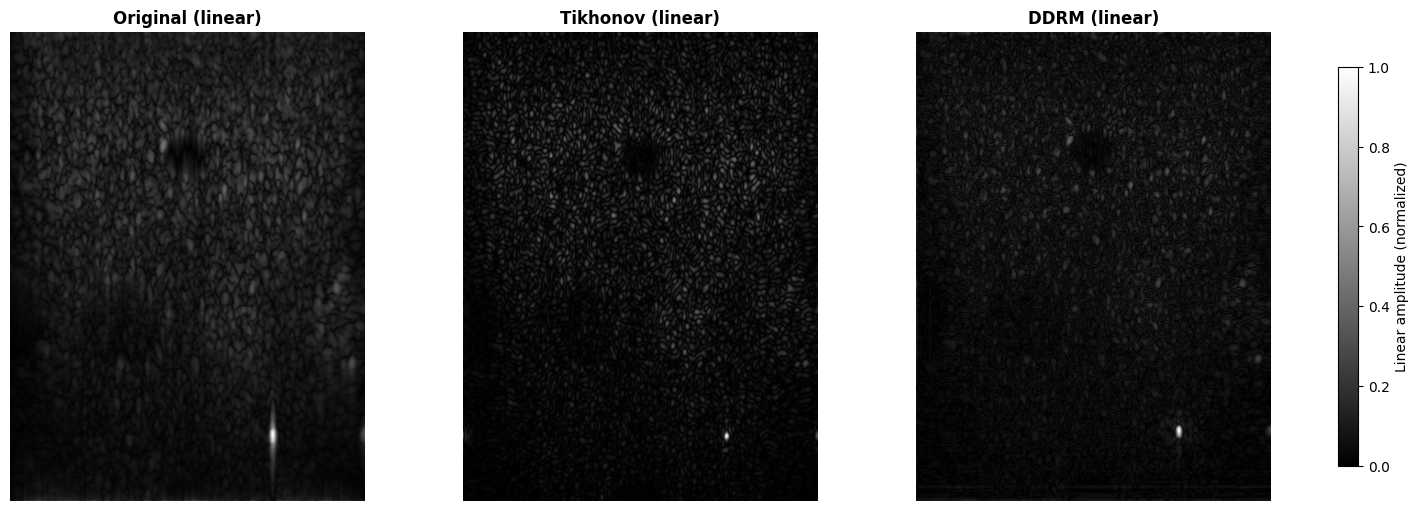

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert

# -----------------------------
# Tikhonov + DDRM side-by-side (exp_data2 + psf_exp2_oleg + 0_-1.mat)
# -----------------------------

# 1) Load RF (original) and PSF
rf = loadmat('exp/datasets/PICMUS/Experimental_Data/exp_data2.mat')['data'].astype(float)
psf_mat = loadmat('exp/datasets/PICMUS/Experimental_Data/new_psf_exp2.mat')

# 2. Tikhonov restoration (Wiener filter)
psf_data = loadmat('exp/datasets/PICMUS/Experimental_Data/new_psf_exp2.mat')
psf = psf_data['cropped_psf']



# 2) Tikhonov (Wiener-like)
rfn = rf / (np.max(np.abs(rf)) + 1e-12)
psf = psf / (np.sum(np.abs(psf)) + 1e-12)
Mh, Nh = psf.shape
M, N = rfn.shape
pad_h = np.zeros_like(rfn)
pad_h[:Mh, :Nh] = psf
pad_h = np.roll(pad_h, -Mh//2, axis=0)
pad_h = np.roll(pad_h, -Nh//2, axis=1)
H = np.fft.fft2(pad_h)
Y = np.fft.fft2(rfn)
SNR_val = 1000.0
VivoTK = np.fft.ifft2((np.conjugate(H) * Y) / (np.conjugate(H) * H + (1.0/SNR_val))).real

# 3) DDRM restoration (load & normalize per your snippet)
ddrm_data = loadmat('exp/image_samples/Picmus_Exp/0_-1.mat')
image = ddrm_data['image'] if 'image' in ddrm_data else ddrm_data[[k for k in ddrm_data if not k.startswith('__')][0]]
if image.ndim == 3:
    image = np.transpose(image, (1, 2, 0))
grayimage = np.mean(image, axis=2) if image.ndim == 3 else image
grayimage = grayimage / np.max(np.abs(grayimage))  # Normalization

# 4) Envelope detection (linear, no log) and crop to common size
M1, N1 = rf.shape
M2, N2 = VivoTK.shape
M3, N3 = grayimage.shape
Mmin, Nmin = min(M1, M2, M3), min(N1, N2, N3)

rf       = rf[:Mmin, :Nmin]
VivoTK   = VivoTK[:Mmin, :Nmin]
grayimage= grayimage[:Mmin, :Nmin]

env_raw = np.abs(hilbert(rf, axis=0));     env_raw /= (env_raw.max() + 1e-12)
env_tik = np.abs(VivoTK);                  env_tik /= (env_tik.max() + 1e-12)
env_ddr = np.abs(grayimage);               env_ddr /= (env_ddr.max() + 1e-12)

# 5) Side-by-side visualization (no log), shared colorbar
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
titles = ['Original (linear)', 'Tikhonov (linear)', 'DDRM (linear)']
for ax, im, t in zip(axes, [env_raw, env_tik, env_ddr], titles):
    imh = ax.imshow(im, cmap='gray', vmin=0, vmax=1, origin='upper', aspect='equal')
    ax.set_title(t, fontsize=12, fontweight='bold')
    ax.axis('off')
cbar = fig.colorbar(imh, ax=axes.ravel().tolist(), shrink=0.85)
cbar.set_label('Linear amplitude (normalized)')
plt.show()


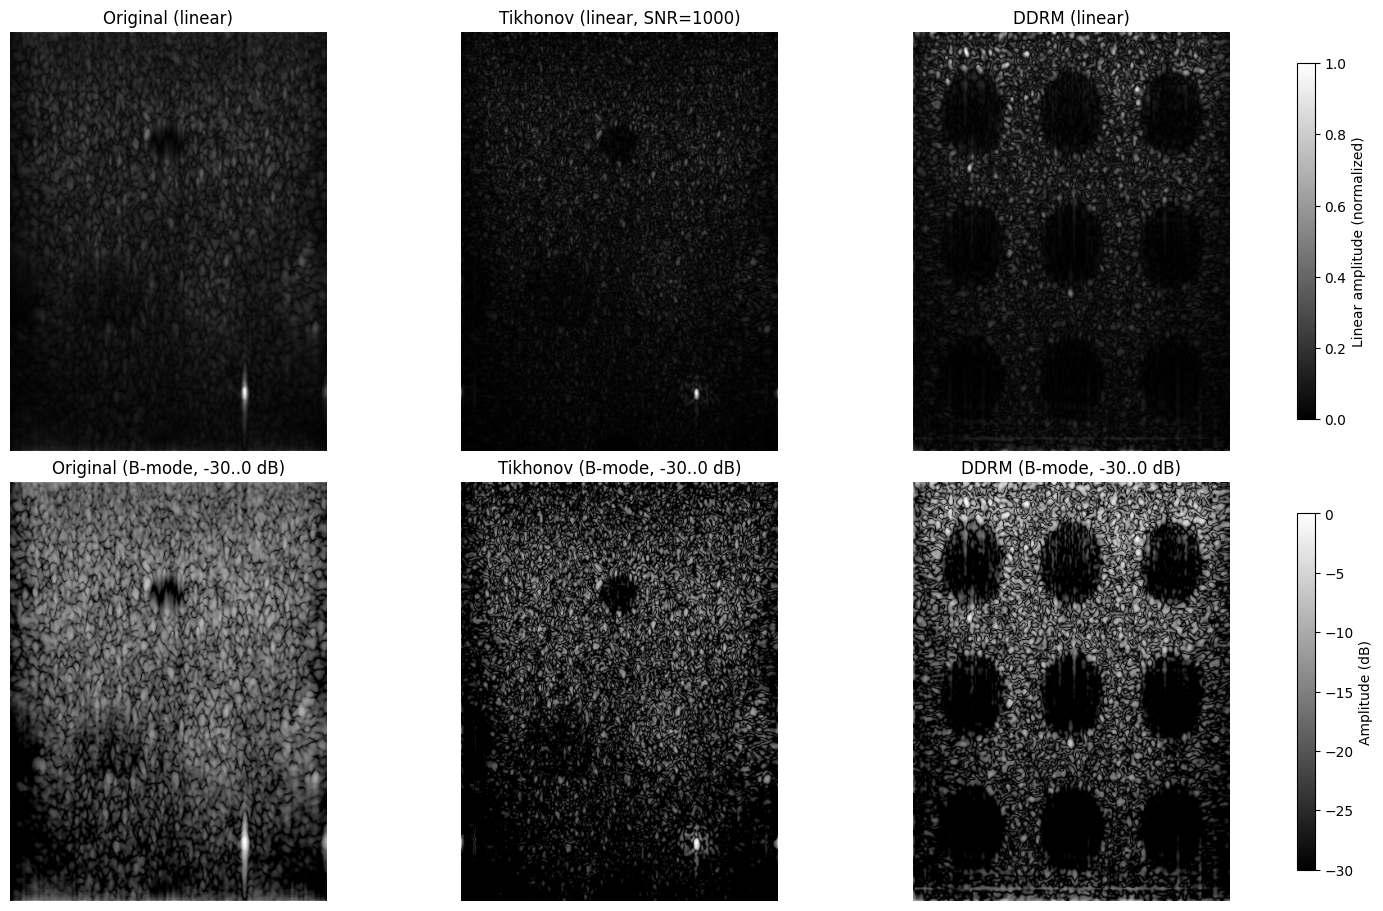

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert

# -----------------------------
# Compare: Original vs Tikhonov vs DDRM (same visualization as before)
#   - Dataset: exp_data2.mat
#   - PSF:     psf_exp2_oleg.mat
#   - DDRM:    0_-1.mat   (uploaded in this session)
# -----------------------------

# 1) Load RF (original) and PSF
rf = loadmat('exp/datasets/PICMUS/Experimental_Data/exp_data2.mat')['data'].astype(float)

psf_mat = loadmat('exp/datasets/PICMUS/Experimental_Data/psf_exp2_oleg.mat')
for k in ('cropped_psf','psf','H','kernel'):
    if k in psf_mat:
        psf = psf_mat[k].astype(float)
        break
else:
    psf = psf_mat[[k for k in psf_mat.keys() if not k.startswith('__')][0]].astype(float)

# 2) Tikhonov (Wiener-like) with SNR=1000 for parity with your last view
rfn = rf / (np.max(np.abs(rf)) + 1e-12)
psf = psf / (np.sum(np.abs(psf)) + 1e-12)
Mh, Nh = psf.shape
M, N = rfn.shape
pad_h = np.zeros_like(rfn)
pad_h[:Mh, :Nh] = psf
pad_h = np.roll(pad_h, -Mh//2, axis=0)
pad_h = np.roll(pad_h, -Nh//2, axis=1)
H = np.fft.fft2(pad_h)
Y = np.fft.fft2(rfn)
SNR_val = 1000.0
VivoTK = np.fft.ifft2((np.conjugate(H) * Y) / (np.conjugate(H) * H + (1.0/SNR_val))).real

# 3) DDRM restoration (load & normalize per your snippet)
#    Using the uploaded DDRM file path available here.
ddrm_data = loadmat('exp/image_samples/Picmus_Exp/0_-1.mat')
image = ddrm_data['image'] if 'image' in ddrm_data else ddrm_data[[k for k in ddrm_data if not k.startswith('__')][0]]
if image.ndim == 3:
    image = np.transpose(image, (1, 2, 0))  # CHW -> HWC if needed
grayimage = np.mean(image, axis=2) if image.ndim == 3 else image
grayimage = grayimage / np.max(np.abs(grayimage))  # Normalization

# 4) Envelope detection (linear, no log) and crop to common size
M1, N1 = rf.shape
M2, N2 = VivoTK.shape
M3, N3 = grayimage.shape
Mmin, Nmin = min(M1, M2, M3), min(N1, N2, N3)

rf       = rf[:Mmin, :Nmin]
VivoTK   = VivoTK[:Mmin, :Nmin]
grayimage= grayimage[:Mmin, :Nmin]

env_raw = np.abs(hilbert(rf, axis=0));     env_raw /= (env_raw.max() + 1e-12)
env_tik = np.abs(VivoTK);                  env_tik /= (env_tik.max() + 1e-12)
env_ddr = np.abs(grayimage);               env_ddr /= (env_ddr.max() + 1e-12)

# 5) Log B-mode function
def bmode_db(env, vmin=-30, vmax=0):
    env = env / (env.max() + 1e-12)
    db = 20*np.log10(env + 1e-12)
    return np.clip(db, vmin, vmax)

b_raw = bmode_db(env_raw, vmin=-30, vmax=0)
b_tik = bmode_db(env_tik, vmin=-30, vmax=0)
b_ddr = bmode_db(env_ddr, vmin=-30, vmax=0)

# 6) Same visualization as before: two rows (linear, B-mode), three columns
fig, axes = plt.subplots(2, 3, figsize=(15, 9), constrained_layout=True)

# Top row: linear envelopes
titles_top = ['Original (linear)', 'Tikhonov (linear, SNR=1000)', 'DDRM (linear)']
for j, im in enumerate([env_raw, env_tik, env_ddr]):
    imh_top = axes[0, j].imshow(im, cmap='gray', vmin=0, vmax=1, origin='upper', aspect='equal')
    axes[0, j].set_title(titles_top[j])
    axes[0, j].axis('off')

# Bottom row: B-mode dB
titles_bot = ['Original (B-mode, -30..0 dB)', 'Tikhonov (B-mode, -30..0 dB)', 'DDRM (B-mode, -30..0 dB)']
for j, im in enumerate([b_raw, b_tik, b_ddr]):
    imh_bot = axes[1, j].imshow(im, cmap='gray', vmin=-30, vmax=0, origin='upper', aspect='equal')
    axes[1, j].set_title(titles_bot[j])
    axes[1, j].axis('off')

# Shared colorbars per row
cb0 = fig.colorbar(imh_top, ax=axes[0, :].ravel().tolist(), shrink=0.85)
cb0.set_label('Linear amplitude (normalized)')
cb1 = fig.colorbar(imh_bot, ax=axes[1, :].ravel().tolist(), shrink=0.85)
cb1.set_label('Amplitude (dB)')

plt.show()


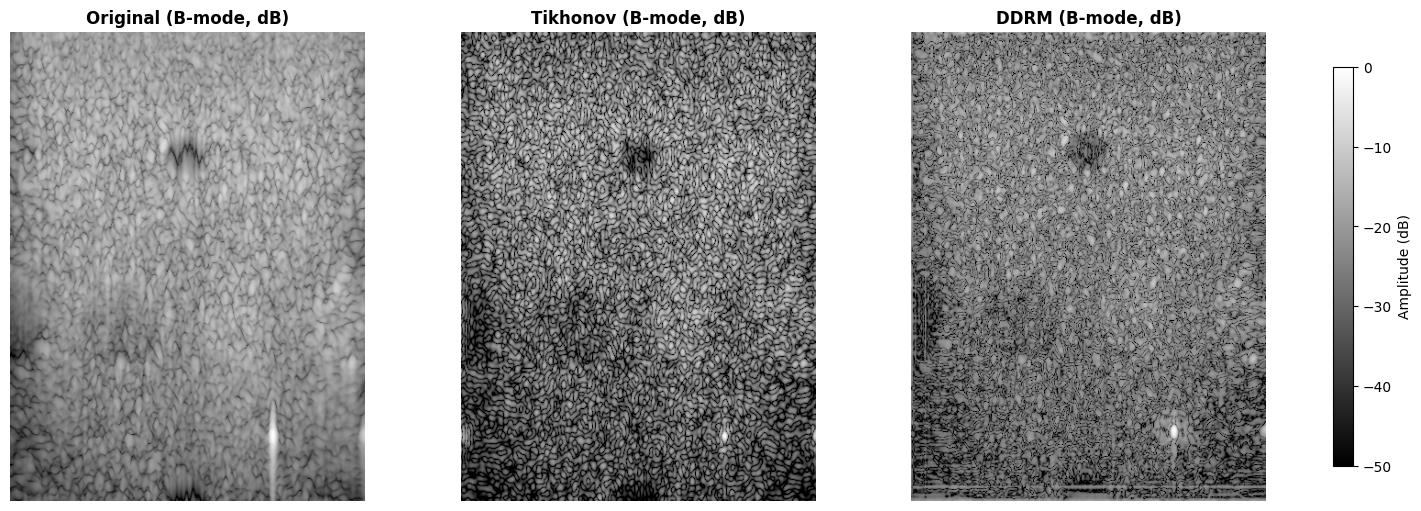

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert

# ------------ Load data (exp_data2 + PSF + DDRM) ------------
rf = loadmat('exp/datasets/PICMUS/Experimental_Data/exp_data2.mat')['data'].astype(float)

psf_mat = loadmat('exp/datasets/PICMUS/Experimental_Data/new_psf_exp2.mat')
for k in ('cropped_psf','psf','H','kernel'):
    if k in psf_mat:
        psf = psf_mat[k].astype(float)
        break
else:
    psf = psf_mat[[k for k in psf_mat if not k.startswith('__')][0]].astype(float)

ddrm_mat = loadmat('exp/image_samples/Picmus_Exp/0_-1.mat')
image = ddrm_mat['image'] if 'image' in ddrm_mat else ddrm_mat[[k for k in ddrm_mat if not k.startswith('__')][0]]
if image.ndim == 3:
    # channel-first -> channel-last
    if image.shape[0] in (1,3):
        image = np.transpose(image, (1,2,0))
grayimage = image.mean(axis=2) if image.ndim == 3 else image
grayimage = np.asarray(grayimage, dtype=float)

# ------------ Tikhonov (Wiener-like) deconvolution ------------
rfn = rf / (np.max(np.abs(rf)) + 1e-12)
psf = psf / (np.sum(np.abs(psf)) + 1e-12)
Mh, Nh = psf.shape
M, N = rfn.shape
pad_h = np.zeros_like(rfn)
pad_h[:Mh, :Nh] = psf
pad_h = np.roll(pad_h, -Mh//2, axis=0)
pad_h = np.roll(pad_h, -Nh//2, axis=1)
H = np.fft.fft2(pad_h)
Y = np.fft.fft2(rfn)
SNR_val = 1000.0
VivoTK = np.fft.ifft2((np.conjugate(H) * Y) / (np.conjugate(H) * H + (1.0/SNR_val))).real

# ------------ Envelopes ------------
env_raw = np.abs(hilbert(rf, axis=0))
env_tik = np.abs(VivoTK)
env_ddr = np.abs(grayimage)

# ------------ Log B-mode (dB) ------------
def bmode_db(env, vmin=-60, vmax=0):
    env = env / (env.max() + 1e-12)
    db = 20*np.log10(env + 1e-12)
    return np.clip(db, vmin, vmax)

b_raw  = bmode_db(env_raw)
b_tik  = bmode_db(env_tik)
b_ddr  = bmode_db(env_ddr)

# Crop all to common size (in case of slight mismatches)
M1,N1 = b_raw.shape; M2,N2 = b_tik.shape; M3,N3 = b_ddr.shape
Mm, Nm = min(M1,M2,M3), min(N1,N2,N3)
b_raw = b_raw[:Mm,:Nm]; b_tik = b_tik[:Mm,:Nm]; b_ddr = b_ddr[:Mm,:Nm]

# ------------ Display side-by-side with shared colorbar ------------
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
titles = ['Original (B-mode, dB)', 'Tikhonov (B-mode, dB)', 'DDRM (B-mode, dB)']
vmin, vmax = -50, 0

for ax, im, t in zip(axes, [b_raw, b_tik, b_ddr], titles):
    imh = ax.imshow(im, cmap='gray', origin='upper', aspect='equal', vmin=vmin, vmax=vmax)
    ax.set_title(t, fontsize=12, fontweight='bold')
    ax.axis('off')

cbar = fig.colorbar(imh, ax=axes.ravel().tolist(), shrink=0.85)
cbar.set_label('Amplitude (dB)')
plt.show()


RF raw range:       min = 0.0006, max = 1.0000
Tikhonov range:     min = -0.2622, max = 1.0000
DDRM range:         min = -0.1144, max = 0.9954


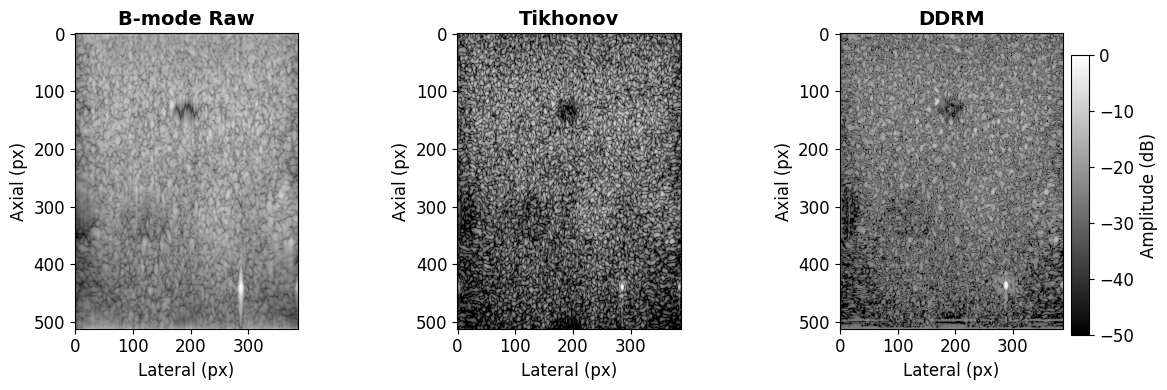

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert

# 1. Load raw RF data
data = loadmat('exp/datasets/PICMUS/Experimental_Data/exp_data2.mat')
rf = data['data']
rfn = rf / np.max(np.abs(rf))  # Normalize RF

# 2. Tikhonov restoration (Wiener filter)
psf_data = loadmat('exp/datasets/PICMUS/Experimental_Data/new_psf_exp2.mat')
H = psf_data['cropped_psf']
h = H / np.sum(np.abs(H))

Mh, Nh = h.shape
Mrf, Nrf = rf.shape
center = np.round([Mh, Nh]) / 2

# Create BCCB degradation operator
pad_h = np.pad(h, ((0, Mrf - Mh), (0, Nrf - Nh)), mode='constant')
pad_h = np.roll(pad_h, int(1 - center[0]), axis=0)
pad_h = np.roll(pad_h, int(1 - center[1]), axis=1)
D = np.fft.fft2(pad_h)

SNR_val = 500  # ~30 dB
VivoTK = np.fft.ifft2(np.fft.fft2(rfn) * np.conj(D) / (1/SNR_val + np.conj(D)*D))
VivoTK = np.real(VivoTK)
VivoTK /= np.max(np.abs(VivoTK))

# 3. DDRM restoration
ddrm_data = loadmat('exp/image_samples/Picmus_Exp/0_-1.mat')
image = ddrm_data['image']
if image.ndim == 3:
    image = np.transpose(image, (1, 2, 0))
grayimage = np.mean(image, axis=2) if image.ndim == 3 else image
grayimage = grayimage / np.max(np.abs(grayimage))  # Normalization

# 4. Envelope detection and log compression
M1, N1 = rf.shape
M2, N2 = VivoTK.shape
M3, N3 = grayimage.shape
M, N = min(M1, M2, M3), min(N1, N2, N3)

# Crop to common size
rf = rf[:M, :N]
VivoTK = VivoTK[:M, :N]
grayimage = grayimage[:M, :N]

# Envelope + Log Compression
env_raw = np.abs(hilbert(rf, axis=0))
env_raw /= np.max(env_raw)
bmode_raw = 20 * np.log10(env_raw + np.finfo(float).eps)

env_tikh = np.abs(VivoTK)
env_tikh /= np.max(env_tikh)
bmode_tikh = 20 * np.log10(env_tikh + np.finfo(float).eps)

env_ddrm = np.abs(grayimage)
env_ddrm /= np.max(env_ddrm)
bmode_ddrm = 20 * np.log10(env_ddrm + np.finfo(float).eps)

# 5. Print statistics
print(f'RF raw range:       min = {np.min(rfn):.4f}, max = {np.max(rfn):.4f}')
print(f'Tikhonov range:     min = {np.min(VivoTK):.4f}, max = {np.max(VivoTK):.4f}')
print(f'DDRM range:         min = {np.min(grayimage):.4f}, max = {np.max(grayimage):.4f}')

# 6. Simplified B-mode Visualization (Only 3 Results + Shared Colorbar + Axial Resolution Labels)
fig = plt.figure(figsize=(12,4))
fig.canvas.manager.set_window_title('B-mode Comparison')

titles = ['B-mode Raw', 'Tikhonov', 'DDRM']
images = [bmode_raw, bmode_tikh, bmode_ddrm]

# Plot all three B-mode results
for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    im = ax.imshow(images[i], cmap='gray', vmin=-50, vmax=0, aspect='equal')
    ax.set_title(titles[i], fontsize=14, fontweight='bold')
    ax.set_xlabel('Lateral (px)', fontsize=12)
    ax.set_ylabel('Axial (px)', fontsize=12)
    ax.tick_params(labelsize=12)
    
    # Add axial resolution annotation (bottom-left corner)


# Add unified colorbar
plt.subplots_adjust(right=0.999995)
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Amplitude (dB)', fontsize=12)
cbar.ax.tick_params(labelsize=12)

#plt.suptitle('Ultrasound B-mode Comparison with Resolution', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [37]:
import numpy as np
from scipy.io import loadmat
from scipy.signal import hilbert
from skimage.metrics import structural_similarity as ssim
import pandas as pd

# ---------- Load Original ----------
rf = loadmat('exp/datasets/PICMUS/Experimental_Data/exp_data1.mat')["data"].astype(float)
env_raw = np.abs(hilbert(rf, axis=0))
env_raw /= (env_raw.max() + 1e-12)

# ---------- Load / Recompute Tikhonov (same as before) ----------
psf = loadmat('exp/datasets/PICMUS/Experimental_Data/new_psf.mat')["cropped_psf"].astype(float)
rfn = rf / (np.max(np.abs(rf)) + 1e-12)
mh, nh = psf.shape
M, N = rfn.shape
pad_h = np.zeros_like(rfn)
pad_h[:mh, :nh] = psf
pad_h = np.roll(pad_h, -mh//2, axis=0)
pad_h = np.roll(pad_h, -nh//2, axis=1)
H = np.fft.fft2(pad_h); Y = np.fft.fft2(rfn)
SNR_val = 1000.0
tikh = np.fft.ifft2((np.conj(H) * Y) / ((np.conj(H)*H) + (1.0/SNR_val))).real
env_tikh = np.abs(tikh); env_tikh /= (env_tikh.max() + 1e-12)

# ---------- Load DDRM output ----------
ddrm_mat = loadmat('exp/image_samples/Picmus_Exp/0_-1.mat')
im = ddrm_mat['image'] if 'image' in ddrm_mat else ddrm_mat[[k for k in ddrm_mat.keys() if not k.startswith('__')][0]]
im = np.asarray(im, dtype=float)
if im.ndim == 3 and im.shape[0] in (1,3):
    im = np.transpose(im, (1,2,0))
ddrm = im.mean(axis=2) if im.ndim == 3 else im.squeeze()
ddrm = ddrm / (np.max(np.abs(ddrm)) + 1e-12)

# ---------- Crop to common size ----------
M1, N1 = env_raw.shape; M2, N2 = env_tikh.shape; M3, N3 = ddrm.shape
Mm, Nm = min(M1,M2,M3), min(N1,N2,N3)
env_raw  = env_raw[:Mm,:Nm]
env_tikh = env_tikh[:Mm,:Nm]
ddrm     = ddrm[:Mm,:Nm]

# ---------- Helper functions ----------
def fwhm_1d(y):
    y = y / (y.max() + 1e-12)
    idx = np.where(y >= 0.5)[0]
    return (idx[-1] - idx[0] + 1) if len(idx) >= 2 else np.nan

def psf_patch(img, half=15):
    Nz, Nx = img.shape
    col = Nx // 2
    row = 150 + np.argmax(img[150:500, col])
    r0, r1 = row-half, row+half+1
    c0, c1 = col-half, col+half+1
    patch = img[max(0,r0):min(Nz,r1), max(0,c0):min(Nx,c1)]
    return np.pad(patch, ((max(0,-r0), max(0,r1-Nz)), (max(0,-c0), max(0,c1-Nx))), mode='edge')

# ---------- Resolution (FWHM) for each ----------
half = 15
p_raw  = psf_patch(env_raw, half)
p_tikh = psf_patch(env_tikh, half)
p_ddrm = psf_patch(ddrm, half)

ax_raw = fwhm_1d(p_raw[:,half]);   lat_raw = fwhm_1d(p_raw[half,:])
ax_tik = fwhm_1d(p_tikh[:,half]);  lat_tik = fwhm_1d(p_tikh[half,:])
ax_ddr = fwhm_1d(p_ddrm[:,half]);  lat_ddr = fwhm_1d(p_ddrm[half,:])

# ---------- PSNR / SSIM vs Original ----------
def psnr(a, b):
    a = a / (a.max() + 1e-12); b = b / (b.max() + 1e-12)
    mse = np.mean((a - b) ** 2)
    return 20*np.log10(1.0 / np.sqrt(mse + 1e-12))

psnr_tikh = psnr(env_raw, env_tikh)
psnr_ddrm = psnr(env_raw, ddrm)
ssim_tikh = ssim(env_raw, env_tikh, data_range=1.0)
ssim_ddrm = ssim(env_raw, ddrm, data_range=1.0)

# ---------- Gains (Original / Method) ----------
gain_ax_tik  = ax_raw / ax_tik if ax_tik>0 else np.nan
gain_lat_tik = lat_raw / lat_tik if lat_tik>0 else np.nan
gain_ax_ddr  = ax_raw / ax_ddr if ax_ddr>0 else np.nan
gain_lat_ddr = lat_raw / lat_ddr if lat_ddr>0 else np.nan

# ---------- Summarize in a table ----------
df = pd.DataFrame({
    'Axial_FWHM_px':   [ax_raw, ax_tik, ax_ddr],
    'Lateral_FWHM_px': [lat_raw, lat_tik, lat_ddr],
    'Gain_Axial_x':    [np.nan, gain_ax_tik, gain_ax_ddr],
    'Gain_Lateral_x':  [np.nan, gain_lat_tik, gain_lat_ddr],
    'PSNR_vs_Orig_dB': [np.nan, psnr_tikh, psnr_ddrm],
    'SSIM_vs_Orig':    [np.nan, ssim_tikh, ssim_ddrm],
}, index=['Original','Tikhonov','DDRM'])

df


Axial_FWHM_px  Lateral_FWHM_px  Gain_Axial_x  Gain_Lateral_x  \
Original             22                6           NaN             NaN   
Tikhonov              7                4      3.142857             1.5   
DDRM                  6                5      3.666667             1.2   

          PSNR_vs_Orig_dB  SSIM_vs_Orig  
Original              NaN           NaN  
Tikhonov        28.809928      0.641553  
DDRM            22.263271      0.103901

In [38]:
# Save the figure
output_path = "exp/image_samples/All_Results_png/comparison.png"
fig.savefig(output_path, dpi=300, bbox_inches='tight')